## Notebook 3: Outlier Detection

This notebook performs Exploratory Data Analysis on the preprocessed dataset from `02_data_preparation.ipynb`.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA # For visualizing outliers if many features

# Setup
np.random.seed(42)
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Seaborn style
try:
    sns.set_theme(style="whitegrid")
except AttributeError:
    try:
        sns.set()
    except Exception:
        plt.style.use('ggplot')

print("Setup complete.")

Setup complete.


### Load Preprocessed Data

In [7]:
preprocessed_data_path = os.path.join(output_dir, 'preprocessed_data_final.ftr')


df_processed = pd.read_feather(preprocessed_data_path)
print(f"Preprocessed data loaded successfully: {preprocessed_data_path}")


# Separate Customer_ID if it was included
customer_id_col = 'Customer_ID'
if customer_id_col in df_processed.columns:
    # customer_ids = df_processed[customer_id_col] # Not needed for this notebook's analysis
    df_analysis = df_processed.drop(columns=[customer_id_col])
else:
    df_analysis = df_processed.copy()

print(f"Shape of data for analysis: {df_analysis.shape}")
display(df_analysis.head())

Preprocessed data loaded successfully: outputs\preprocessed_data_final.ftr
Shape of data for analysis: (3030, 11)


,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity,Casino_Potential_Class
0,1,2,0.0,0.0,0.0,3,1,3.0,3.0,0.0,0.0
1,1,2,0.0,0.0,0.0,3,0,2.0,2.0,0.0,0.0
2,1,2,0.0,0.0,0.0,3,0,2.0,2.0,0.0,0.0
3,1,2,0.0,0.0,0.0,3,1,3.0,3.0,0.0,0.0
4,1,2,0.0,0.0,0.0,3,1,3.0,3.0,0.0,0.0


### Outlier Detection (Categorical Combination Frequency)

In [13]:
import pandas as pd

# Drop non-feature columns
features = df_analysis.drop(columns=['Customer_ID', 'Cluster'], errors='ignore')

# Create a combination column
features['Combination'] = features.astype(str).agg('-'.join, axis=1)

# Count frequencies
combo_counts = features['Combination'].value_counts()

# Define threshold (e.g., frequency < 5)
threshold = 2
outlier_combinations = combo_counts[combo_counts < threshold].index

# Flag outliers
df_analysis['Is_Outlier'] = features['Combination'].isin(outlier_combinations).astype(int)

# Save results
#df_outliers.to_csv("outputs/outlier_detection_results.csv", index=False)

# Summarize
outliers = df_analysis[df_analysis['Is_Outlier'] == 1]
print(f"Number of outliers detected: {len(outliers)}")
print("\nSample of outliers:")
print(outliers.head())

Number of outliers detected: 656

Sample of outliers:
    Seasonality_Segment  EA_Segment  Revenue_Bucket  Profit_Bucket  \
9                     0           2             1.0            3.0   
13                    3           0             2.0            3.0   
14                    3           0             3.0            3.0   
15                    2           2             2.0            3.0   
18                    1           2             1.0            3.0   

    Market_Share_Segment  Churn_Segment  Competitiveness_Flag  Volume_Segment  \
9                    1.0              2                     1             3.0   
13                   1.0              2                     1             3.0   
14                   0.0              2                     1             3.0   
15                   2.0              2                     1             3.0   
18                   3.0              2                     1             3.0   

    Density_Segment  Propensity  Casin

### Outlier Detection - Isolation Forest


Performing outlier detection using Isolation Forest...
Number of outliers detected by Isolation Forest: 152 (5.02%)

Sample of detected outliers (first 5):


,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity,Casino_Potential_Class,outlier_isoforest
14,3,0,3.0,3.0,0.0,2,1,3.0,1.0,2.0,0.0,-1
22,3,0,2.0,3.0,2.0,2,1,2.0,0.0,3.0,4.0,-1
39,0,0,3.0,3.0,2.0,2,0,3.0,1.0,3.0,4.0,-1
49,0,1,1.0,1.0,3.0,2,0,1.0,0.0,2.0,3.0,-1
103,0,3,3.0,3.0,2.0,2,1,2.0,0.0,2.0,4.0,-1


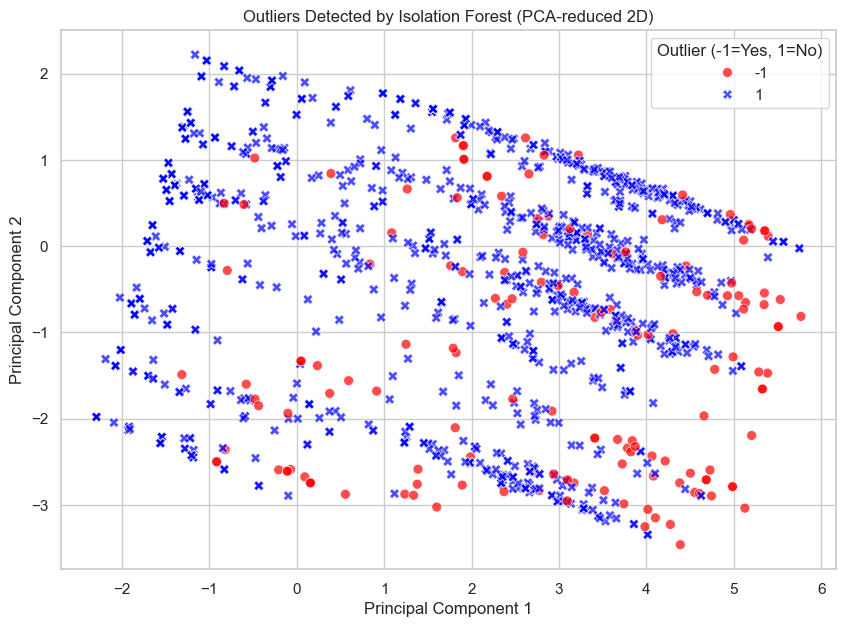

In [8]:
if df_analysis.empty:
    print("Skipping Isolation Forest: Data for analysis is empty.")
elif df_analysis.isnull().values.any():
    print("Data contains NaNs. Isolation Forest cannot handle NaNs. Please ensure data is fully imputed in Notebook 2.")
else:
    print("Performing outlier detection using Isolation Forest...")
    # Contamination: expected proportion of outliers. 'auto' or a float e.g. 0.05 (5%)
    # Using a small fixed value for reproducibility, 'auto' can vary.
    iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42, n_jobs=-1)
    
    try:
        outlier_preds = iso_forest.fit_predict(df_analysis)
        # -1 indicates an outlier, 1 indicates an inlier.
        df_analysis_copy = df_analysis.copy() # Work on a copy to avoid modifying df_analysis directly here
        df_analysis_copy['outlier_isoforest'] = outlier_preds
        
        num_outliers = (outlier_preds == -1).sum()
        outlier_percentage = (num_outliers / len(df_analysis_copy)) * 100
        
        print(f"Number of outliers detected by Isolation Forest: {num_outliers} ({outlier_percentage:.2f}%)")
        
        print("\nSample of detected outliers (first 5):")
        display(df_analysis_copy[df_analysis_copy['outlier_isoforest'] == -1].head())
        
        # Visualize outliers if possible (using PCA for dimensionality reduction)
        if df_analysis.shape[1] > 2 and num_outliers > 0:
            pca = PCA(n_components=2, random_state=42)
            components = pca.fit_transform(df_analysis) # Use original df_analysis for PCA
            df_pca_outliers = pd.DataFrame(data=components, columns=['PC1', 'PC2'], index=df_analysis.index)
            df_pca_outliers['outlier'] = outlier_preds # Add outlier predictions from iso_forest
            
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='PC1', y='PC2', hue='outlier', style='outlier', data=df_pca_outliers, palette={1: 'blue', -1: 'red'}, s=50, alpha=0.7)
            plt.title('Outliers Detected by Isolation Forest (PCA-reduced 2D)')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend(title='Outlier (-1=Yes, 1=No)')
            plt.savefig(os.path.join(output_dir, 'isolation_forest_outliers_pca.png'))
            plt.show()
        elif num_outliers == 0:
            print("No outliers detected by Isolation Forest with current settings.")
        else: # 2 or fewer features
            print("Skipping PCA visualization for outliers as data has <=2 features or no outliers.")
            
    except ValueError as e:
        print(f"Error during Isolation Forest: {e}. This might be due to data issues not caught earlier.")